In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
!pip install polars
!pip install openpyxl
!pip install pingouin

In [62]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from scipy.stats import bootstrap
import scipy.stats as stats
import polars as pl
import warnings
import pingouin as pg

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.7f}'.format
np.random.seed(42)

In [89]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1, n_resamples=20000)
    #fig, ax = plt.subplots()
    #ax.hist(res.bootstrap_distribution, bins=25)
    #ax.set_title('Bootstrap Distribution')
    #ax.set_xlabel(stat_label)
    #ax.set_ylabel('frequency')
    #plt.show()
    return res

def histo(df):
    df.hist()
    plt.tight_layout()
    plt.show()

In [4]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [5]:
dfreco = pl.read_parquet("recommendations.parquet")#.set_index('review_id')
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)

In [6]:
dfreco.to_pandas().describe()

,app_id,helpful,funny,hours,user_id,review_id
count,"41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000"
mean,"603,272.3585402",3.2025669,1.0580709,100.6022378,"7,450,576.0049239","20,577,396.5000000"
std,"472,923.2816550",46.9364857,28.6706028,176.1675413,"4,010,685.0333110","11,880,365.8415090"
min,10.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,"253,940.0000000",0.0000000,0.0000000,7.8000000,"4,287,256.0000000","10,288,698.2500000"
50%,"435,150.0000000",0.0000000,0.0000000,27.3000000,"7,546,445.5000000","20,577,396.5000000"
75%,"933,110.0000000",0.0000000,0.0000000,99.2000000,"10,968,770.7500000","30,866,094.7500000"
max,"2,253,290.0000000","36,212.0000000","28,109.0000000","1,000.0000000","14,306,063.0000000","41,154,793.0000000"


In [7]:
dfreco.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [8]:
# Summarize data to the user id level
df = dfreco.to_pandas().groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'nunique', 'is_recommended':'sum', 'hours':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})


In [17]:
df.describe()

,helpful,funny,products,recommended,hours,single_pca,single_pca_sort
count,"13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000"
mean,9.5639224,3.1597490,2.9863288,2.5618059,300.4315106,-0.0000000,305.2094727
std,126.4814068,58.3653193,8.1180071,6.5223299,516.2289609,130.5712739,417.2120791
min,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,-10.1012235,0.0001077
25%,0.0000000,0.0000000,1.0000000,1.0000000,28.6000000,-10.1012235,163.6521824
50%,0.0000000,0.0000000,1.0000000,1.0000000,114.6000000,-10.0793288,255.5899899
75%,2.0000000,0.0000000,3.0000000,2.0000000,388.4000000,-8.1521527,294.0633269
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000","79,844.6315709","290,676.3714859"


In [18]:
# Max hours seems high, let's constrain to only hours that would fall within the date range of the platform life
import datetime
data1 = datetime.datetime(2003, 1, 1, 0, 0, 0) #First Possible Launch of Steam
data2 = datetime.datetime.now() 

diff = data2 - data1
hours = diff.days * 24 + diff.seconds // 3600
df = df[df.hours <= hours]

In [22]:
from sklearn.decomposition import PCA

features = ['products','helpful','funny', 'hours', 'recommended']
X = df[features].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]

In [23]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance with Hours")

,products,helpful,funny,hours,recommended
0,0.008105,0.051694,0.014595,0.998501,0.006655


In [24]:
features = ['products','helpful','funny', 'hours', 'recommended']
df[features].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny,hours,recommended
products,1.000000,0.355315,0.155228,0.502803,0.940144
helpful,0.355315,1.000000,0.510948,0.193609,0.344657
funny,0.155228,0.510948,1.000000,0.118559,0.152089
hours,0.502803,0.193609,0.118559,1.000000,0.513675
recommended,0.940144,0.344657,0.152089,0.513675,1.000000


In [25]:
features = ['products','helpful','funny']
df[['products','helpful','funny']].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny
products,1.000000,0.355315,0.155228
helpful,0.355315,1.000000,0.510948
funny,0.155228,0.510948,1.000000


In [26]:
from sklearn.decomposition import PCA

X = df[features].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
#df['single_pca_sort'] = df.single_pca.abs()


In [27]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

,products,helpful,funny
0,0.021808,0.963543,0.266664


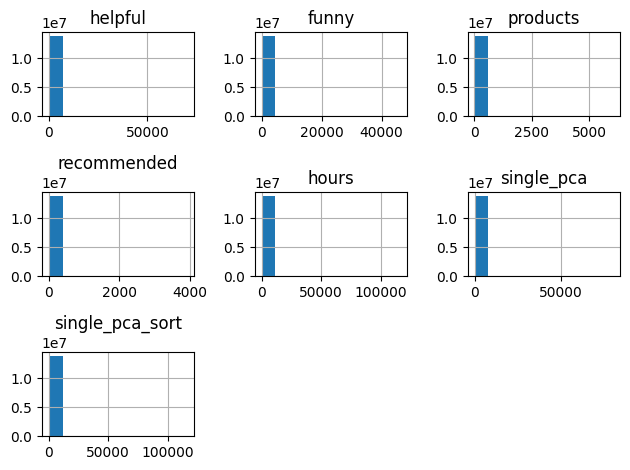

In [28]:
histo(df)
df = df[(df.helpful > 0)&(df.funny > 0)&(df.recommended > 0)&(df.recommended < df.products)&(df.products>10)]

df['helpful_rat'] = df.helpful / df.products
df['funny_rat'] = df.funny / df.products
df['recommended_rat'] = df.recommended / df.products
df['hours_rat'] = df.hours / df.products

df = df[df['single_pca'] >= np.percentile(df['single_pca'].values, 95)]

In [30]:
df.describe()

,helpful,funny,products,recommended,hours,single_pca,single_pca_sort,helpful_rat,funny_rat,recommended_rat,hours_rat
count,"14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000"
mean,"1,801.0083964",515.0198460,78.3939352,60.5879536,"3,099.8651100","1,864.2738696","2,898.3391800",46.0537295,16.2141629,0.7913544,64.3605207
std,"2,474.1977253","1,035.1205136",141.7842265,100.2415456,"3,395.6814157","2,506.1444450","3,418.8875663",64.8067680,37.1373645,0.1610865,56.7679832
min,278.0000000,2.0000000,11.0000000,1.0000000,3.1000000,678.9902451,0.1452803,0.4546875,0.0061350,0.0084034,0.2583333
25%,822.0000000,92.0000000,22.0000000,17.0000000,"1,276.7000000",853.2175997,"1,058.4119193",15.0000000,1.6394444,0.7142857,26.8804440
50%,"1,113.0000000",234.0000000,42.0000000,33.0000000,"2,285.9000000","1,159.7681650","2,070.3337466",29.0789474,4.9506173,0.8333333,48.3785714
75%,"1,796.0000000",582.0000000,85.0000000,68.0000000,"3,830.0000000","1,869.4521824","3,641.1168122",55.1166038,15.4156545,0.9142857,83.4475160
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","73,729.9000000","79,849.3392262","74,412.6303289","2,116.0434783",999.7692308,0.9988675,889.8714286


In [32]:
X = df[features].values
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X)
scores = iso.decision_function(X)

df["iso"] = outliers
df["iso_score"]  = scores
df['type'] = df['iso'].apply(lambda x: "Outlier" if x == -1 else "Inlier")

In [33]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns_order = ['Outlier', 'Inlier']

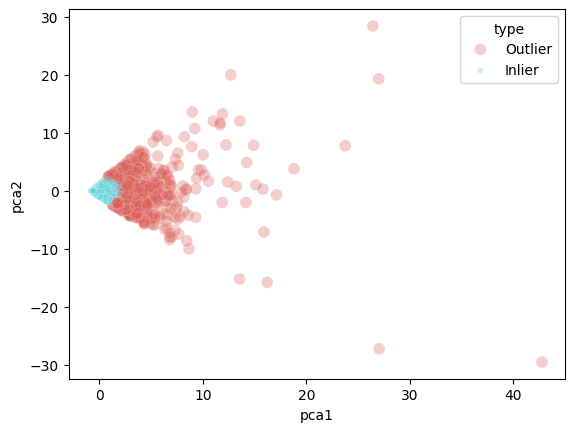

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="pca1", 
    y="pca2", 
    hue="type",
    hue_order = sns_order,
    legend=True,
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [36]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

,products,helpful,funny
0,0.487219,0.692260,0.532347
1,0.743312,-0.008776,-0.668887


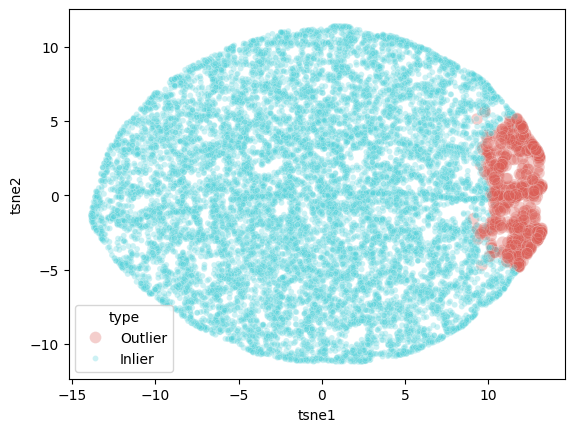

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X)

df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    hue_order = sns_order,
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [38]:
df_outliers = df[df.iso == -1]
#df_outliers = df_outliers[df_outliers.hours <= hours]

cols = ['user_id', 'products','helpful','funny', 'hours', 'recommended', 'helpful_rat', 'funny_rat', 'recommended_rat', 'hours_rat']
df_outliers = df_outliers.sort_values(by='single_pca', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()

,user_id,helpful,funny,products,recommended,hours,single_pca,single_pca_sort,helpful_rat,funny_rat,recommended_rat,hours_rat,iso,iso_score,type,pca1,pca2,tsne1,tsne2
1,5860500,70096,46186,129,107,"3,922.6000000","79,849.3392262","7,915.5627498",543.3798450,358.0310078,0.8294574,30.4077519,-1,-0.2210494,Outlier,42.7716670,-29.4902262,13.2146635,-2.2235298
2,8040965,65990,1132,1673,1633,"7,642.1000000","63,912.4103245","10,782.3603285",39.4441124,0.6766288,0.9760909,4.5679020,-1,-0.2367140,Outlier,23.7572932,7.7337084,13.2246485,0.6902679
3,9231134,53730,2310,1056,762,"7,558.6000000","52,400.0516547","10,071.6119613",50.8806818,2.1875000,0.7215909,7.1577652,-1,-0.2217766,Outlier,18.8124792,3.7811859,13.2188082,0.6247423
4,11446587,49721,1511,428,325,"12,392.4000000","48,310.4484862","14,671.2670190",116.1705607,3.5303738,0.7593458,28.9542056,-1,-0.1713359,Outlier,15.1217296,1.0192926,13.2058563,0.5641607
5,352264,48669,2929,23,22,313.8000000,"47,666.0991750","2,571.7838476","2,116.0434783",127.3478261,0.9565217,13.6434783,-1,-0.1448775,Outlier,14.1648934,-2.0166182,13.2006168,0.5273528


In [39]:
df_outliers[cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          721 non-null    int64  
 1   products         721 non-null    int64  
 2   helpful          721 non-null    int64  
 3   funny            721 non-null    int64  
 4   hours            721 non-null    float64
 5   recommended      721 non-null    int64  
 6   helpful_rat      721 non-null    float64
 7   funny_rat        721 non-null    float64
 8   recommended_rat  721 non-null    float64
 9   hours_rat        721 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 62.0 KB


In [40]:
df_outliers[cols].drop('user_id', axis=1).describe()

,products,helpful,funny,hours,recommended,helpful_rat,funny_rat,recommended_rat,hours_rat
count,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000
mean,352.1775312,"8,354.6449376","2,519.8848821","6,407.1113731",254.2968100,113.0512129,60.4523958,0.7942355,44.8966951
std,491.5059049,"7,482.3437923","3,523.5304777","7,798.1025880",330.9682229,194.5373004,118.6085982,0.1796119,55.1318339
min,11.0000000,601.0000000,4.0000000,141.1000000,1.0000000,0.4546875,0.0083160,0.0084034,0.8693522
25%,47.0000000,"3,486.0000000",459.0000000,"2,434.9000000",39.0000000,13.6857798,1.0159490,0.7246575,12.1596330
50%,201.0000000,"7,019.0000000","1,348.0000000","4,378.7000000",154.0000000,44.6756757,7.4600000,0.8385965,26.7432099
75%,489.0000000,"10,542.0000000","3,735.0000000","7,640.1000000",351.0000000,125.0000000,59.9821429,0.9253731,58.8200000
max,"6,045.0000000","70,096.0000000","46,186.0000000","73,729.9000000","3,920.0000000","2,116.0434783",999.7692308,0.9988675,512.0131944


In [41]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers[cols].style.format(precision=2))

,user_id,products,helpful,funny,hours,recommended,helpful_rat,funny_rat,recommended_rat,hours_rat
1,5860500,129,70096,46186,3922.60,107,543.38,358.03,0.83,30.41
2,8040965,1673,65990,1132,7642.10,1633,39.44,0.68,0.98,4.57
3,9231134,1056,53730,2310,7558.60,762,50.88,2.19,0.72,7.16
4,11446587,428,49721,1511,12392.40,325,116.17,3.53,0.76,28.95
5,352264,23,48669,2929,313.80,22,2116.04,127.35,0.96,13.64
6,11451103,620,44896,4202,16059.40,563,72.41,6.78,0.91,25.90
7,5112758,4152,42745,3510,8404.20,3920,10.30,0.85,0.94,2.02
8,3963306,433,42050,1997,6437.20,387,97.11,4.61,0.89,14.87
9,8865664,879,39597,7905,8199.50,872,45.05,8.99,0.99,9.33
10,8568403,617,36180,2369,12589.70,462,58.64,3.84,0.75,20.40


In [42]:
print(f'Original user count: {dfreco.to_pandas().user_id.nunique()}')
print(f'User candidate count: {len(df)}')
print(f'Anomaly user count: {len(df_outliers)}')

Original user count: 13781059
User candidate count: 14411
Anomaly user count: 721


In [43]:
df_outliers.to_excel('outlier_users.xlsx')

In [74]:
res = pg.ttest(df_outliers['helpful'], df['helpful'], paired=False, alternative='greater', correction='auto')
print(res)

                T         dof alternative     p-val           CI95%   cohen-d  \
T-test 23.4545788 727.8981174     greater 0.0000000  [6093.45, inf] 2.2485995   

              BF10     power  
T-test  7.315e+115 1.0000000  


In [102]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(df_outliers['single_pca'], df['single_pca'], alternative='greater')
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 9591574.5
p-value: 0.0


In [73]:
features = ['products','helpful','funny', 'hours', 'recommended']
print(df_outliers[features].median()) 
print(df[features].median()) 

products        201.0000000
helpful       7,019.0000000
funny         1,348.0000000
hours         4,378.7000000
recommended     154.0000000
dtype: float64
products         42.0000000
helpful       1,113.0000000
funny           234.0000000
hours         2,285.9000000
recommended      33.0000000
dtype: float64


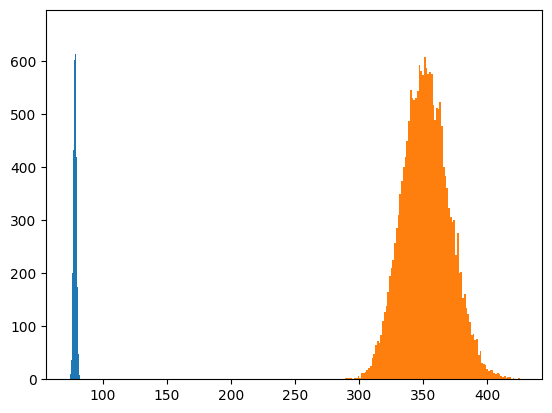

ConfidenceInterval(low=76.57182339702958, high=80.46698328681201)
ConfidenceInterval(low=324.9428238504693, high=385.79930690592306)


In [97]:
A = boot(df, 'products', np.mean, 'PCA 1')
B = boot(df_outliers,'products', np.mean, 'PCA 1')
plt.hist(A.bootstrap_distribution, bins=100)
plt.hist(B.bootstrap_distribution, bins=100)
plt.show()
print(A.confidence_interval)
print(B.confidence_interval)